In [1]:
import numpy as np
import pandas as pd
import os
from hmmlearn.hmm import GaussianHMM
from datetime import datetime
from tqdm.notebook import tqdm

fldr = os.path.abspath(os.path.join(os.getcwd(), '..'))
freq_str = 'W-Wed'

In [2]:
rt_ff = pd.read_pickle(f'{fldr}/data/ff.pkl')
rt_ff = rt_ff.add(1).groupby(pd.Grouper(freq=freq_str)).prod().sub(1)
rt_ff.drop(['rf', 'umd'], axis=1, inplace=True)

rt = pd.read_pickle(f'{fldr}/data/rt_sp.pkl')
is_tradable = pd.read_pickle(f'{fldr}/data/is_tradable_sp.pkl')
meta = pd.read_pickle(f'{fldr}/data/meta_sp.pkl')

<AxesSubplot:>

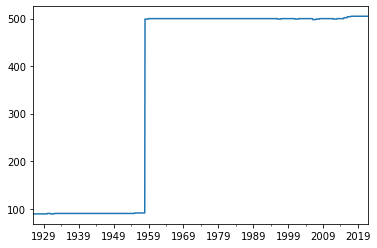

In [3]:
is_tradable.sum(axis=1).plot()
# Before 1959 there is a drop in membership, for some reason. I can start my backtest after that date?

In [4]:
rebalance_dts = pd.date_range(start=datetime(1959, 12, 31), end=datetime(2021, 12, 31), freq='BM')
n_states = 4
fetch_sigma = {}
fetch_mu = {}
fetch_fitres = {}
fetch_smoothed = {}
for dt in tqdm(rebalance_dts[:10]):
    training = rt_ff.loc[:dt]
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.01)
    model.fit(training.values)

    # I NEED TO SORT THE STATES, SO 1 is always (for example) crisis

    # print(f'Model converged: {model.monitor_.converged}')
    s_prob = pd.DataFrame(model.predict_proba(training.values), index=training.index)
    fetch_smoothed[dt] = model.predict_proba(training.values)
    fetch_mu[dt] = model.means_  # Find an efficient way of labeling
    fetch_sigma[dt] = model.covars_


Model is not converging.  Current: 15335.286727025914 is not greater than 15335.294018290846. Delta is -0.007291264932064223
Model is not converging.  Current: 15498.321884182267 is not greater than 15498.328276892298. Delta is -0.006392710030922899


In [16]:
var_s = pd.concat([pd.Series(np.diag(model.covars_[x])) for x in range(n_states)], axis=1)
var_s.T

,0,1,2
0,0.000824,0.000273,0.000560
1,0.004327,0.000960,0.002099
2,0.000256,0.000060,0.000089
3,0.003821,0.001025,0.000623


In [17]:
var_s.mean() # Separate in high/low, do the same with the means

0    0.000552
1    0.002462
2    0.000135
3    0.001823
dtype: float64

In [19]:
model.means_

array([[ 1.25294789e-03,  1.80752906e-03,  5.10415819e-04],
       [ 1.37418619e-04,  8.61069890e-04,  2.82594622e-03],
       [ 3.05352214e-03,  6.05883908e-05,  3.93300344e-04],
       [-9.88891324e-03, -3.10916352e-03,  4.27562559e-03]])

In [33]:
training

,mktrf,smb,hml
date,,,
1926-07-07,0.008120,-0.008593,-0.006987
1926-07-14,0.006764,-0.007209,0.006672
1926-07-21,-0.007436,0.007401,-0.011482
1926-07-28,0.011556,-0.005216,-0.005097
1926-08-04,0.019212,-0.015712,-0.009549
...,...,...,...
1960-08-31,-0.017417,0.014369,-0.006895
1960-09-07,-0.019918,0.001900,0.002795
1960-09-14,-0.006845,-0.002802,0.001797


,0,1,2,3
date,,,,
1926-07-07,9.691009e-56,1.176969e-139,1.000000,1.096669e-59
1926-07-14,1.897644e-04,5.011539e-15,0.999559,2.515864e-04
1926-07-21,4.246450e-04,1.620607e-10,0.999192,3.833770e-04
1926-07-28,3.501352e-04,5.670049e-10,0.999349,3.013461e-04
1926-08-04,8.876743e-04,1.440638e-09,0.996500,2.612618e-03
...,...,...,...,...
1960-08-31,2.251809e-03,7.910071e-09,0.996193,1.555287e-03
1960-09-07,2.057713e-03,4.166766e-08,0.997292,6.497761e-04
1960-09-14,3.310525e-03,2.416253e-07,0.995910,7.794845e-04


In [39]:
training = rt.dropna()  # Training set
lengths = [len(training[c]) for c in training]
training_longform = training.melt(ignore_index=False, var_name='factor', value_name='return')
training_longform
# training_longform = training_longform.reset_index().set_index(['factor', 'date']).loc[['mktrf', 'smb', 'hml']]
# X = training_longform['return'].values.reshape(-1, 1)

,factor,return
date,,


Model is not converging.  Current: 43850.57220648244 is not greater than 43850.632418551046. Delta is -0.060212068608962


4 hidden states.


<AxesSubplot:>

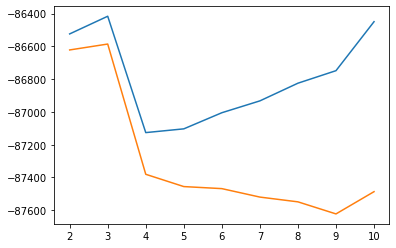

In [45]:
training = rt_ff.dropna()  # Training set
# lengths = [len(training[c]) for c in training]
# training_longform = training.melt(ignore_index=False, var_name='factor', value_name='return')
# training_longform = training_longform.reset_index().set_index(['factor', 'date']).loc[['mktrf', 'smb', 'hml']]
# X = training_longform['return'].values.reshape(-1, 1)
X = training.values

states_to_try = range(2, 11)
bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
for n in states_to_try:
    mdl = GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
    # mdl.fit(X, lengths)
    mdl.fit(X)
    bic[n] = mdl.bic(X)
    # bic[n] = mdl.bic(X, lengths)
    aic[n] = mdl.aic(X)
    # aic[n] = mdl.aic(X, lengths)

n_states = bic.idxmin()
print(f'{n_states} hidden states.')

bic.plot()
aic.plot()

In [46]:
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0)
model.fit(training.values)
# model.fit(training.values)
print(f'Model converged: {model.monitor_.converged}')

# Find a way of sorting the states

hidden_states = model.predict(training.values)
smoothed_prob = model.predict_proba(training.values)
mu_s = model.means_  # Find an efficient way of labeling
sigma_s = model.covars_

Model converged: True


In [50]:
hidden_states

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [48]:
sigma_s

array([[[ 6.07170590e-04,  8.29087965e-06, -1.51015375e-04],
        [ 8.29087965e-06,  1.64853710e-04, -2.36265951e-05],
        [-1.51015375e-04, -2.36265951e-05,  1.84724651e-04]],

       [[ 7.41557034e-04,  2.05665087e-04,  3.80375006e-04],
        [ 2.05665087e-04,  2.15424968e-04,  1.39346908e-04],
        [ 3.80375006e-04,  1.39346908e-04,  4.04899707e-04]],

       [[ 1.90828673e-04,  1.58413722e-05,  1.05203853e-05],
        [ 1.58413722e-05,  6.51719825e-05,  5.13071897e-06],
        [ 1.05203853e-05,  5.13071897e-06,  6.05027573e-05]],

       [[ 3.61275470e-03,  1.43551776e-04,  1.00773228e-03],
        [ 1.43551776e-04,  9.61136139e-04, -1.14910728e-04],
        [ 1.00773228e-03, -1.14910728e-04,  1.53970370e-03]]])

In [ ]:
# import matlab.engine
# eng = matlab.engine.start_matlab()
# # eng.cd(r'myFolder', nargout=0)
# # eng.myFnc()
# mdl_base = eng.varm(3.0, 1.0)
# mdl_base_fit = eng.estimate(mdl_base, rt.values)
# eng.summarize(mdl_base_fit)